# __프로젝트: 뉴스기사 요약해보기__

## 목차
### STEP. 0. 라이브러리📚 호출 🗣️
### STEP. 1 데이터 전처리
- 1. 데이터 가져오기
- 2. 중복값 및 Null값 제거
- 3. 불🔥용어 제거
- 4. 샘플의 길이📏 정하기
- 5. 토큰 🪙
- 6. 단어집합 만들기
- 7. Padding

### STEP. 2 어텐션 메커니즘 사용하기
### STEP. 3 실제 결과와 요약문 비교하기
### STEP. 4 Summa을 이용해서 추출적 요약해보기
### STEP. 5 회고

## STEP 0. 라이브러리📚 호출 🗣️

In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
import urllib.request
import requests
from summa.summarizer import summarize
from tqdm import tqdm

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## STEP. 1 데이터 전처리

### 1. 데이터 가져오기

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(20)

,headlines,text
55298,"Rajkummar Rao, Alia Bhatt named Hottest Vegeta...",Rajkummar Rao and Alia Bhatt have been named t...
86594,"Aus, NZ take a point each as match abandoned d...",The second match of the Champions Trophy 2017 ...
79952,Priyanka made acting debut in 2002 Tamil film ...,"Actress Priyanka Chopra, who turned 35 on Tues..."
42236,19-yr-old Rashid Khan fastest to 100 wickets i...,Afghan spinner Rashid Khan has become the fast...
96882,Health Minister tables bill to decriminalise s...,Union Health Minister JP Nadda has presented a...
85464,BJP's Patra falls for fake news while tweeting...,BJP spokesperson Sambit Patra fell for a fake ...
4668,O Raja reinducted following forget & forgive p...,The AIADMK on Wednesday said Tamil Nadu Deputy...
21217,Came to Mumbai from a village to become a good...,"Rajpal Yadav, while talking about his journey ..."
31826,Regret dating him before divorce: SmithÃ¢ÂÂs...,Actor Jada Pinkett Smith said she regretted da...
8898,Ensure our citizens' safety: China to Pak afte...,Following the terror attack on the Chinese con...


### 2. 중복값 및 Null값 제거

In [4]:
print('뉴스📰의 핵심 headline에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('기사📰의 본문에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

뉴스📰의 핵심 headline에서 중복을 배제한 유일한 샘플의 수 : 98280
기사📰의 본문에서 중복을 배제한 유일한 샘플의 수 : 98360


In [5]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [6]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [7]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


### 3. 불🔥용어 제거

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
#데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (test)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [12]:
data.sample(1)
data['headlines'][0]

'upGrad learner switches to career in ML & Al with 90% salary hike'

In [13]:
temp_text = data['text'][0]
temp_headlines = data['headlines'][0]

print(temp_text)
print(temp_headlines)
print()
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
upGrad learner switches to career in ML & Al with 90% salary hike

saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers
upgrad learner switches to career in ml al with salary hike


In [14]:
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['text']):
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
clean_text[:5]

100%|██████████| 98360/98360 [09:08<00:00, 179.39it/s]


['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [15]:
clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in tqdm(data['headlines']):
    clean_headlines.append(preprocess_sentence(s, False))

clean_headlines[:5]

100%|██████████| 98360/98360 [00:17<00:00, 5540.78it/s]


['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [16]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [17]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [18]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))#데이터 전처리 함수

전체 샘플수 : 98360


### 4. 샘플의 길이📏 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


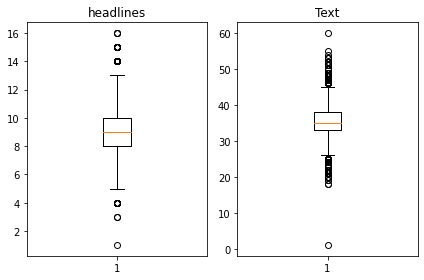

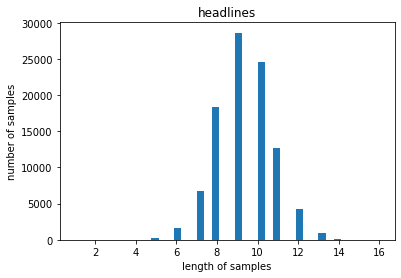

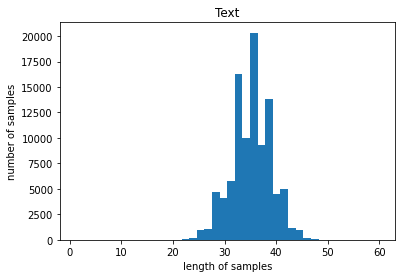

In [19]:
# 길이 분포 출력

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
text_max_len = 50
headlines_max_len = 8

In [21]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [22]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [23]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 27105


### 5. 토큰 🪙

In [24]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


In [25]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25250  3631 10879 ... 13739 17712  1619]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [28]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 5421


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


### 6. 단어집합 만들기

In [30]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42485
등장 빈도가 6번 이하인 희귀 단어의 수: 30738
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11747
단어 집합에서 희귀 단어의 비율: 72.35024126162175
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.282244893128505


In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [33]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

#잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[2266, 150, 1070, 1238, 13, 3976, 193, 706, 51, 1321, 1881, 18, 45, 48, 685, 262, 1619, 18, 47, 30, 838, 193], [82, 2391, 1903, 6219, 2930, 2357, 1092, 336, 71, 998, 877, 59, 23, 1431, 1322, 2391, 1092, 2391, 21, 365, 1652, 2391, 998, 2517, 539, 2], [5992, 145, 730, 55, 355, 15, 1206, 909, 59, 3698, 246, 447, 2931, 3309, 302, 84, 24, 17, 2392, 1139, 186, 2825, 402, 1638, 2267, 1722, 1882, 6]]


In [34]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18907
등장 빈도가 5번 이하인 희귀 단어의 수: 14268
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4639
단어 집합에서 희귀 단어의 비율: 75.4641138202782
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.153715799521649


In [36]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 1530, 455, 6, 3, 485], [1, 4, 1619, 3, 1453], [1, 1620, 4, 71, 497, 43], [1, 179, 552, 594, 537, 1159], [1, 28, 878, 19, 30, 38]]
target
decoder  [[1530, 455, 6, 3, 485, 2], [4, 1619, 3, 1453, 2], [1620, 4, 71, 497, 43, 2], [179, 552, 594, 537, 1159, 2], [28, 878, 19, 30, 38, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 10
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 21674
훈련 레이블의 개수 : 21674
테스트 데이터의 개수 : 5417
테스트 레이블의 개수 : 5417


### 7. Padding

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

### 모델 설계

### 인코더, 디코더 설계

In [39]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

## STEP. 2 Attention Mechanism

In [40]:
# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## STEP. 3 모델 훈련

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 40)

Epoch 1/40
85/85 [==============================] - 14s 79ms/step - loss: 4.9296 - val_loss: 4.5391
Epoch 2/40
85/85 [==============================] - 6s 66ms/step - loss: 4.5307 - val_loss: 4.3406
Epoch 3/40
85/85 [==============================] - 6s 65ms/step - loss: 4.3510 - val_loss: 4.2172
Epoch 4/40
85/85 [==============================] - 6s 66ms/step - loss: 4.2073 - val_loss: 4.0988
Epoch 5/40
85/85 [==============================] - 6s 66ms/step - loss: 4.0741 - val_loss: 4.0071
Epoch 6/40
85/85 [==============================] - 6s 67ms/step - loss: 3.9443 - val_loss: 3.8957
Epoch 7/40
85/85 [==============================] - 6s 66ms/step - loss: 3.8136 - val_loss: 3.8089
Epoch 8/40
85/85 [==============================] - 6s 67ms/step - loss: 3.6900 - val_loss: 3.7260
Epoch 9/40
85/85 [==============================] - 6s 67ms/step - loss: 3.5702 - val_loss: 3.6464
Epoch 10/40
85/85 [==============================] - 6s 67ms/step - loss: 3.4580 - val_loss: 3.5815
Epoch 11

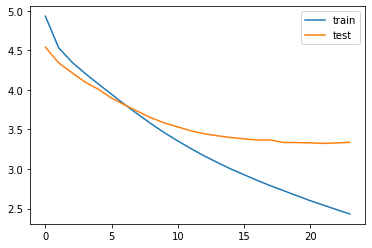

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Inference model 구현

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [51]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")
    print("\n")

원문 : flipkart singapore based parent entity controlled walmart reportedly invested around crore india wholesale subsidiary flipkart india private limited investment reportedly made december bengaluru based commerce platform also set gross value around lakh crore next target reports added 
실제 요약 : walmart invests cr in flipkart india arm reports 
예측 요약 :  flipkart invests crore in india arm




원문 : seventh season hbo series game thrones streamed crore times per report anti firm total instances season crore times within first hours 
실제 요약 : game of season illegally cr times 
예측 요약 :  wins cr in crore




원문 : scotland given pink high visibility protection cross road house owner said couple like go path sometimes across road thought would keep safe put 
실제 요약 : to cross the road 
예측 요약 :  uk to get its own




원문 : russian football club rubin youth team player confused goalkeeper converting penalty national student league match ran take penalty performed backward ball spot goalkeeper cou

## STEP. 4 Extractive summarization

In [47]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [53]:
for idx, (head, text) in enumerate(zip(data['headlines'], data['text'])):
    if idx == 20:
        break
    print("원문 :", text)
    print("실제 요약 :", head)
    print("예측 요약 :", summarize(text, ratio=0.5))
    print("\n")
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.




원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill p

## STEP. 5 회고

제가 재미있는 사실을 발견했습니다.  
남춘식 하면 뭔가요! 춘식이의 실험실이죠  

### 춘식이의 실험실  
저는 한 가지 신기한 걸 발견했고 궁금한 게 생겼습니다  .  

바로 ratio입니다.  
ratio는 한국어로 번역 하면 비율입니다  
근데 이 ratio를 적게 줄이면 어떻게 될까요?  

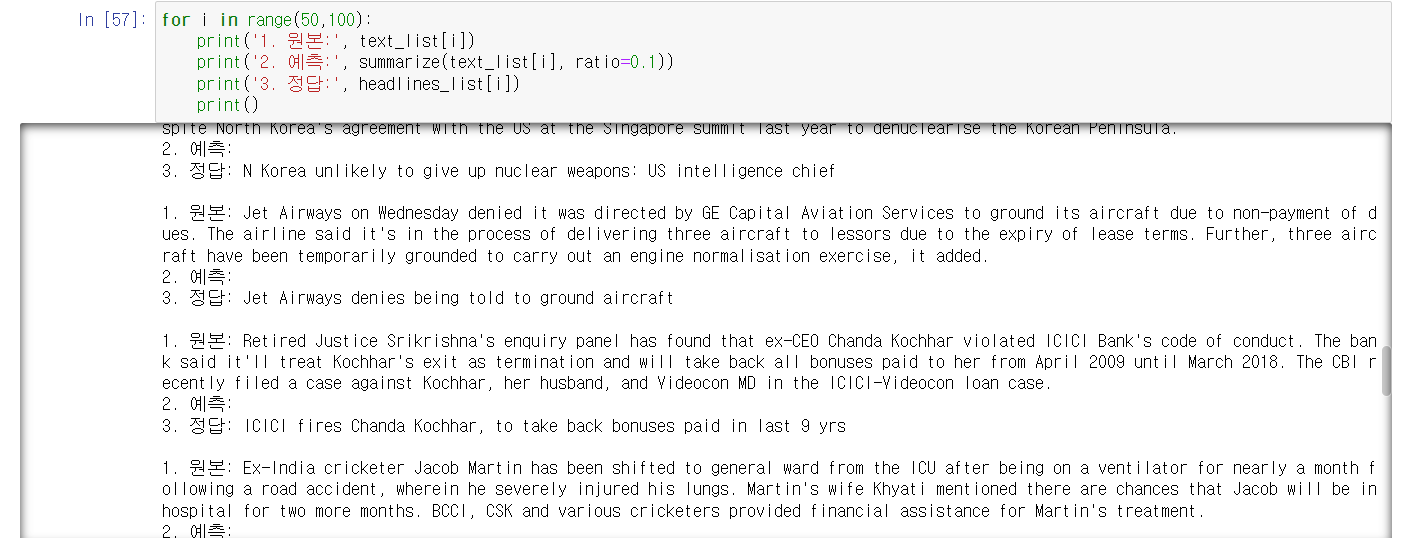  
0.1로 설정을 하니.. 예측값이 아예 나오지 않았습니다.  

왜 그럴까요? 0.2도 한번 볼까요?  
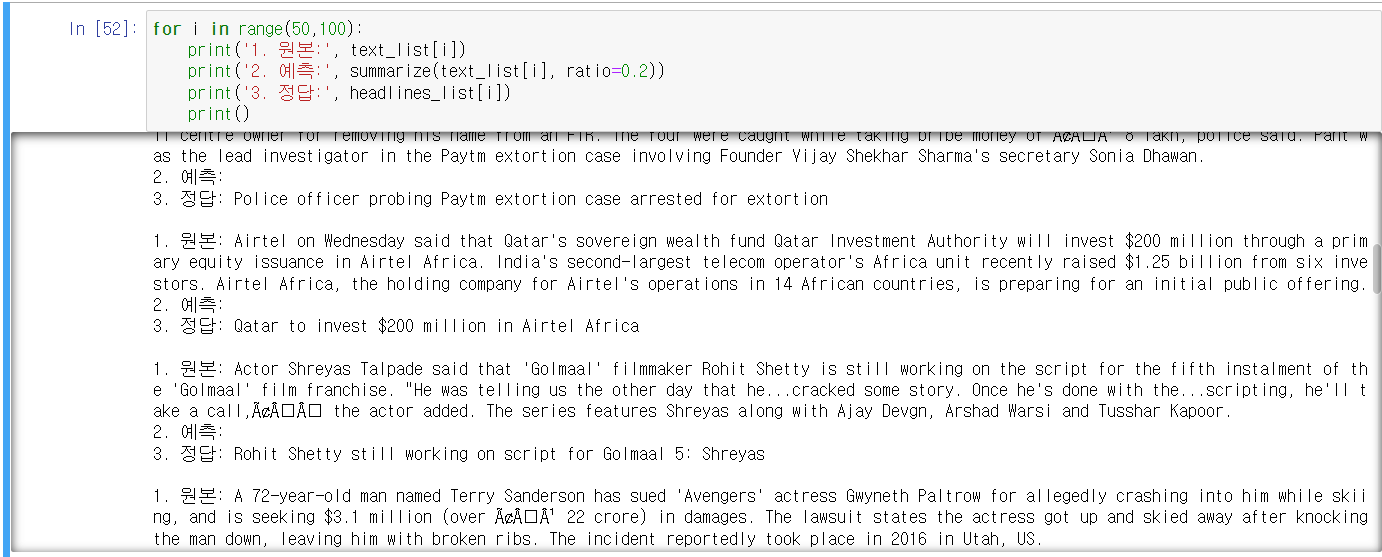  
0.2 역시도 예측이 하나도 되지 않았습니다...ㅠ  

그럼 1로 한번 볼까요?  
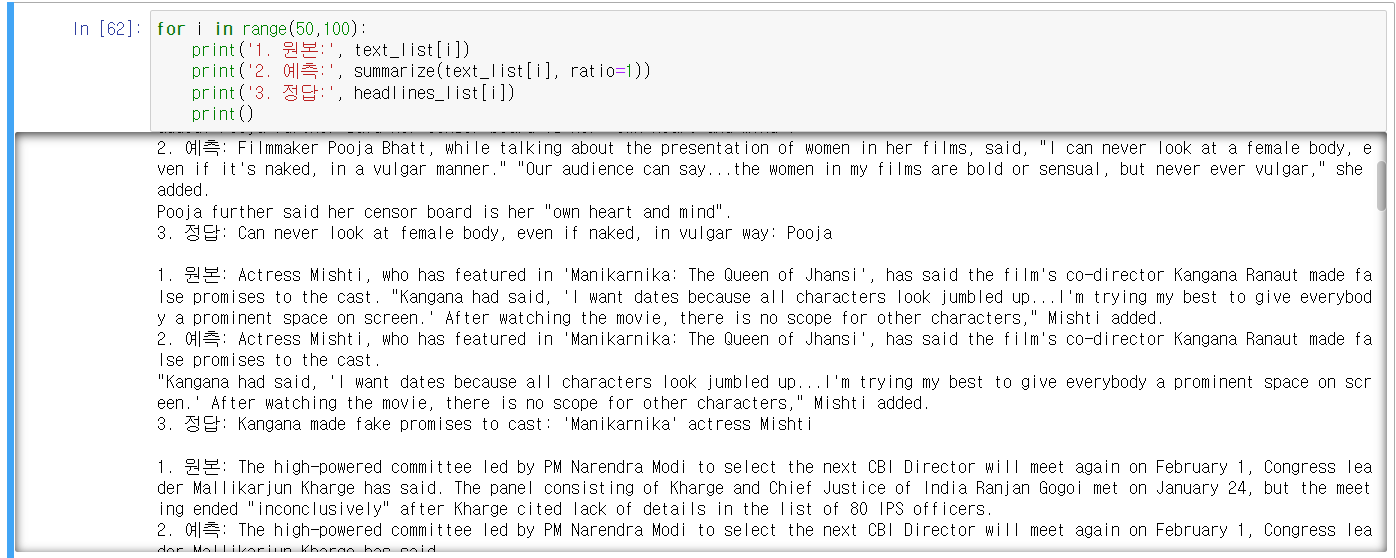  
1로 하면 거의 본문을 통째로 가져옵니다.  
우리가 이걸로 알 수 있는 것은 Abstractive Summarization가 Extractive Summarization보다 성능이 더 좋으며 이말은 즉 딥러닝이 머신러닝 보다 성능이 더 좋다는 것을 의미한다고 생각합니다.